ValueError: decay is deprecated in the new Keras optimizer, pleasecheck the docstring for valid arguments, or use the legacy optimizer, e.g., tf.keras.optimizers.legacy.Adam.

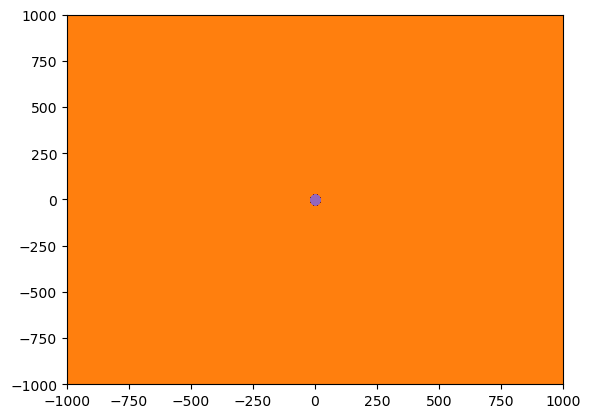

In [3]:
#!/usr/bin/env python
# coding: utf-8

# # Here is your code

# ### Intialize the system

# In[1]:


### Test

import os
import numpy as np
import numpy.matlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import pandas as pd
import matplotlib.pyplot as plt
from scenario import scenario
import time

import pickle

from calcMSE import calcMSE
from statsmodels.distributions.empirical_distribution import ECDF

from rss_transform import rss_transform
from build_model_FF import build_model
# from myloss import myloss

K = 20
dim = 2
alpha = 2
beta = 1
w = 1000
target_seed = 0
sensor_seed = 1
pmin = 1
pmax = 1
scaler_file = 'minmax_scaler.sav'
log_base = np.exp(1)

N = 2
M = int(1e5)
EPOCHS = 10000
learn_rate = float(3*1e-6)
beta1_val = 0.9
beta2_val = 0.99
decay_val = int(1e-4)
lam = 1



if_y_scale = False
if_x_scale = False
if_sensor_scale = False


if_y_scale = True
if_x_scale = True
if_sensor_scale = True
scaling_type = "maxmin"
scaling_type = "multiply"



# # Scale the data

# In[2]:


rss, pos_target, pos_sensor = scenario(N,K,dim,alpha,beta,M,pmax,pmin,w,sensor_seed,target_seed)
Y = np.squeeze(pos_target,axis=2)
X = rss_transform(rss,log_base)

for n in range(0,N):
    plt.scatter(Y[:,n,0],Y[:,n,1])
# print(Y[:1,:])
plt.xlim([-w,w])
plt.ylim([-w,w])


# scaler_X = StandardScaler()
# scaler_Y = StandardScaler()
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

# from sklearn.preprocessing import Normalizer
# scaler_X =  Normalizer()
# scaler_Y =  Normalizer()

scaler_X.fit(X)
if if_x_scale ==True:
    X = scaler_X.transform(X)

if if_y_scale == True:
    if scaling_type == "maxmin":
        y = Y.reshape(-1,1)
        scaler_Y.fit(y)
        y_scaled = scaler_Y.transform(y)
        Y = y_scaled.reshape(((np.size(Y,0),np.size(Y,1),np.size(Y,2))))    
        if if_sensor_scale == True:
            y = pos_sensor.reshape(-1,1)    
            y_scaled = scaler_Y.transform(y)
            pos_sensor = y_scaled.reshape(((np.size(pos_sensor,0),np.size(pos_sensor,1),np.size(pos_sensor,2),np.size(pos_sensor,3))))    
    elif scaling_type == "multiply":
        Y = Y / w
        if if_sensor_scale == True:
            pos_sensor = pos_sensor / w
        

    


# In[3]:


for n in range(0,N):
    plt.scatter(Y[:,n,0],Y[:,n,1])
# plt.xlim([-0.5,0.5])
# plt.ylim([-0.5,0.5])

plt.scatter(pos_sensor[:,:,:,0],pos_sensor[:,:,:,1])


# In[4]:


def myloss(y_true,y_pred):
#     N = tf.shape(y_true).get_shape().as_list()
    distance = tf.norm(y_true[:,:,tf.newaxis,:] - pos_sensor, ord='euclidean',
                  axis=3,
                  keepdims=None,
                  name=None,
                  keep_dims=None
                  )
    dist_power = keras.backend.pow(distance, -alpha)
    rss_true = keras.backend.sum(dist_power, axis = 1)

    distance = tf.norm(y_pred[:,:,tf.newaxis,:] - pos_sensor, ord='euclidean',
                  axis=3,
                  keepdims=None,
                  name=None,
                  keep_dims=None
                  )
    dist_power = keras.backend.pow(distance, -alpha)
    rss_pred = keras.backend.sum(dist_power, axis = 1)
    
    rss_true = keras.backend.log(rss_true) / np.log(log_base)
    rss_pred = keras.backend.log(rss_pred) / np.log(log_base)
    loss1 = keras.losses.mean_squared_error(rss_true, rss_pred)
#     loss = keras.backend.log(loss) / np.log(log_base)




#     y_true = tf.transpose(y_true, perm=[0, 2, 1])
#     y_pred = tf.transpose(y_pred, perm=[0, 2, 1])        
    y_true = tf.reshape(y_true,shape=(-1,N*dim))    
    y_pred = tf.reshape(y_pred,shape=(-1,N*dim))    
    mse = keras.losses.mean_squared_error(y_true,y_pred)
#         perm_mat = np.array([[0,1,0,0],[1,0,0,0],[0,0,0,1],[0,0,1,0]],dtype=np.float32)
    if N == 2:
        perm_mat = np.array([[0,0,1,0],[0,0,0,1],[1,0,0,0],[0,1,0,0]],dtype=np.float32)        
    else:
        perm_mat = np.array([[0,1],[1,0]],dtype=np.float32)            
        perm_mat = np.array([[1,0],[0,1]],dtype=np.float32)            
    y_perm = tf.matmul(y_true,perm_mat)        
    mse_perm = keras.losses.mean_squared_error(y_perm,y_pred)            
    mse = tf.minimum(mse,mse_perm)    
    loss = (1-lam)*loss1 + (lam)*mse
    return loss 


# In[5]:


# from itertools import permutations

# def myloss(y_true,y_pred):
#     y_true = tf.reshape(y_true,shape=(-1,N*dim))    
#     y_pred = tf.reshape(y_pred,shape=(-1,N*dim))    
#     loss = keras.losses.mean_squared_error(y_true,y_pred)    
#     I = indetity_mat(N*dim)
#     for m in permutations(I):
#         perm_mat = np.array(m,dtype=np.float32)
#         y_perm = tf.matmul(y_true,perm_mat)
#         loss_tmp = keras.losses.mean_squared_error(y_perm,y_pred)
#         loss = tf.minimum(loss,loss_tmp)    
#     return loss 

# def indetity_mat(n):
#     I = []
#     for i in range(n):
#         I.append([1 if j == i else 0 for j in range(n)])
#     return I


X = X.reshape(X.shape[0],-1,1)
model = build_model(X,K,N,dim)

# optimizer = tf.keras.optimizers.RMSprop(0.001)
optimizer = keras.optimizers.Adam(lr=learn_rate, beta_1=beta1_val, beta_2=beta2_val, epsilon=None, decay=decay_val, amsgrad=True)
# optimizer =  keras.optimizers.SGD(lr=1e-3, clipnorm=1.)


# In[ ]:


model.compile(loss=myloss,optimizer=optimizer,metrics=['mean_squared_error', myloss])
# model.compile(loss='mean_squared_error',optimizer=optimizer,metrics=['mean_squared_error',myloss])


#print(clf.summary())

callbacks = [EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=10, verbose=0, mode='auto'),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)]
callbacks = []

start = time.time()
history = model.fit(X,Y,epochs=EPOCHS, validation_split = 0.1, verbose=1, callbacks = callbacks)

end = time.time()
elapsed = end - start
print("elapsed time: "+str(elapsed)+" sec")

## serialize model to JSON
#model_json = model.to_json()
#with open("model.json", "w") as json_file:
#    json_file.write(model_json)
## serialize weights to HDF5
model.save_weights("model.h5")
#print("Saved model to disk")

pickle.dump([scaler_X,scaler_Y], open(scaler_file, 'wb'))

#M = int(1e4)
#target_seed = 71212
rss_test, pos_target_test, pos_sensor = scenario(N,K,dim,alpha,beta,M,pmax,pmin,w,sensor_seed,target_seed)

Xt = rss_transform(rss_test,log_base)
if if_x_scale ==True:
    Xt = scaler_X.transform(Xt)


Xt = Xt.reshape(Xt.shape[0],-1,1)
result = model.predict(Xt)
result = np.transpose(result, axes=(0,2,1))
result = result.reshape(M,N*dim)
if if_y_scale == True:
    if scaling_type == "maxmin":
        result = scaler_Y.inverse_transform(result)
    elif scaling_type == "multiply":
            result = result*w
            pos_sensor = pos_sensor*w
Tx_hat = result[:,:N]
Ty_hat = result[:,N:]

Yt = np.squeeze(pos_target_test,axis=2)
Tx_test = Yt[:,:,0]
Ty_test = Yt[:,:,1]
MSE = calcMSE(Tx_test.T,Ty_test.T,Tx_hat.T,Ty_hat.T)
mse = MSE.reshape(1,-1)[0]
print("Mean error: "+str(np.mean(mse)))
print("Mean error: "+str(np.var(mse)))
for e in [0.1,1,10,100,1000]:
  prob=(mse > e).sum()/M*100
  print("Pr(e>"+str(e)+"m)= "+str(prob)+"%")
